In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (auc, confusion_matrix, precision_recall_curve,
                             r2_score, roc_curve)
import plot_misspec as pm


In [3]:
d_type = "aft"
lab_dict = {"neut": 0, "ssv": 1, "sdn": 2}
dict_lab = {v:k for k,v in lab_dict.items()}
scenarios = ["Constant", "Bottleneck", "OoA"]

df_dict = {}
for r_idx, s1 in enumerate(scenarios):
    for c_idx, s2 in enumerate(scenarios):
        df = pd.read_csv(f"results/data/{s1.lower()}_on_{s2.lower()}_{d_type}.csv")
        df["pred"] = [dict_lab[i] for i in df["pred_sweep"].values]
        df["int_swp"] = [lab_dict[i] for i in df["sweep"].values]
        name = f"{s1}_on_{s2}"
        df = pd.read_csv(f"results/data/{s1.lower()}_on_{s2.lower()}_{d_type}.csv")
        df["pred"] = [dict_lab[i] for i in df["pred_sweep"].values]
        df["int_swp"] = [lab_dict[i] for i in df["sweep"].values]
        name = f"{s1}_on_{s2}"
        
        df_dict[name] = df

In [4]:
df_dict["Constant_on_Constant"].head()

,rep,sweep,pred_sweep,neut_prob,ssv_prob,sdn_prob,s_val,sdn_sval,ssv_sval,pred,int_swp
0,0,neut,0,0.628596,0.238581,0.132824,0.0,0.058811,0.059316,neut,0
1,1,neut,0,0.470559,0.183353,0.346088,0.0,0.056401,0.040859,neut,0
2,10,neut,0,0.693012,0.172857,0.134131,0.0,0.033701,0.029266,neut,0
3,100,neut,0,0.757236,0.116087,0.126677,0.0,0.033177,0.049381,neut,0
4,1000,neut,0,0.662214,0.178043,0.159743,0.0,0.031083,0.026279,neut,0


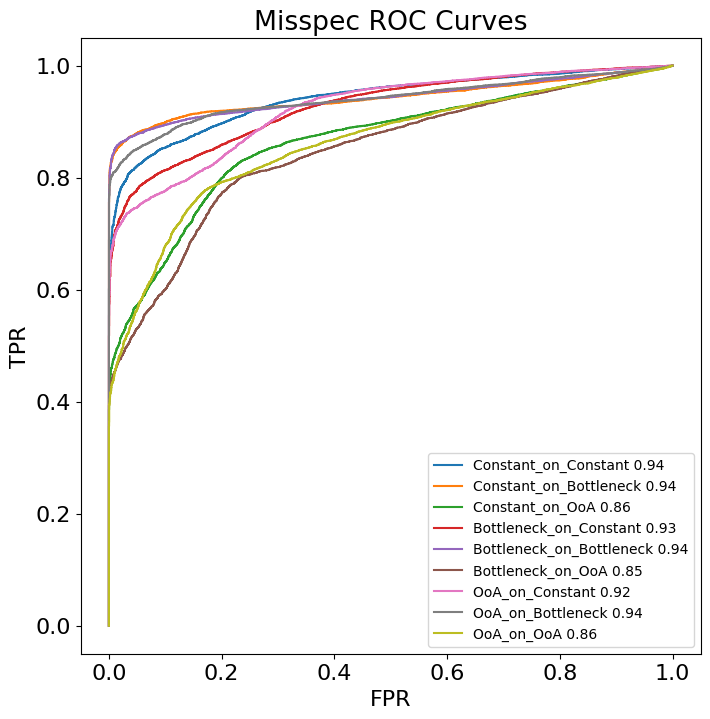

In [5]:
aucs = []
for i in df_dict.keys():
    swp_fpr, swp_tpr, swp_auc_val, fpr, tpr, auc_val = pm.plot_roc(df_dict[i])
    aucs.append(auc_val)
    plt.plot(fpr, tpr, label=f"{i} {auc_val:.2}")
    
#handles, labels = plt.gca().get_legend_handles_labels()

#order = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(aucs))][::-1]
plt.legend( fontsize=10)
plt.title("Misspec ROC Curves")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.savefig("Misspec_sweep_roc.pdf")

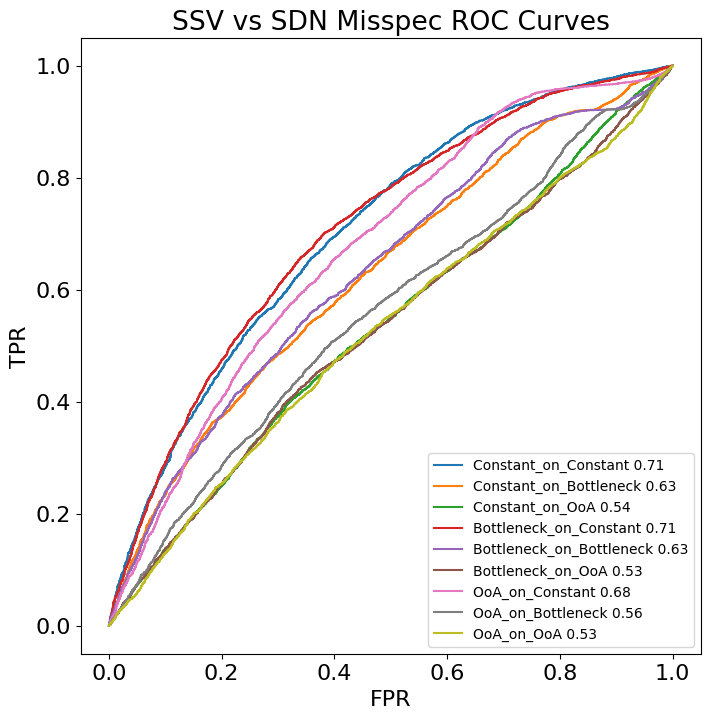

In [6]:
swp_aucs = []
for i in df_dict.keys():
    swp_fpr, swp_tpr, swp_auc_val, fpr, tpr, auc_val = pm.plot_roc(df_dict[i])
    swp_aucs.append(swp_auc_val)
    plt.plot(swp_fpr, swp_tpr, label=f"{i} {swp_auc_val:.2}")
    
handles, labels = plt.gca().get_legend_handles_labels()

order = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(swp_aucs))][::-1]
plt.legend(fontsize=10)
plt.title("SSV vs SDN Misspec ROC Curves")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.savefig("Misspec_SDNSSV_ROC.pdf")

In [7]:
def plot_prec_recall(data):
    """Plot PR curve by binarizing neutral/sweep."""
    data = df_dict[i]
    sweep_idxs = np.transpose(np.array((data["int_swp"] > 0)).nonzero())
    sweep_labs = np.array(data["int_swp"])[sweep_idxs]

    sdn_probs = data[data["int_swp"] > 0]["sdn_prob"]

    swp_prec, swp_rec, thresh = precision_recall_curve(sweep_labs, sdn_probs, pos_label=2)
    swp_auc_val = auc(swp_rec, swp_prec)

    # Coerce all ssvs into sweep binary pred
    labs = np.array(data["int_swp"])
    labs[labs > 1] = 1
    pred_probs = np.sum(np.array([data["sdn_prob"], data["ssv_prob"]]).T, axis=1)

    # Plot ROC Curve
    prec, rec, thresh = precision_recall_curve(labs, pred_probs)
    auc_val = auc(rec, prec)
    
    
    return swp_prec, swp_rec, swp_auc_val, prec, rec, auc_val

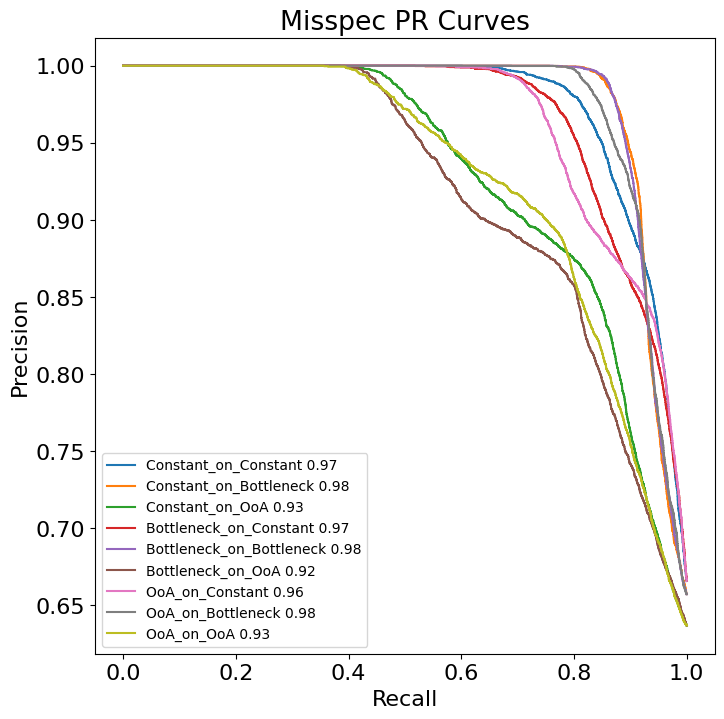

In [8]:
swp_aucs = []
for i in df_dict.keys():
    swp_prec, swp_rec, pr_swp_auc, prec, rec, pr_auc = plot_prec_recall(df_dict[i])
    swp_aucs.append(pr_auc)
    plt.plot(rec, prec, label=f"{i} {pr_auc:.2}")
    
handles, labels = plt.gca().get_legend_handles_labels()

order = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(aucs))][::-1]
plt.legend(fontsize=10)
plt.title("Misspec PR Curves")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.savefig("Misspec_sweep_PR.pdf")

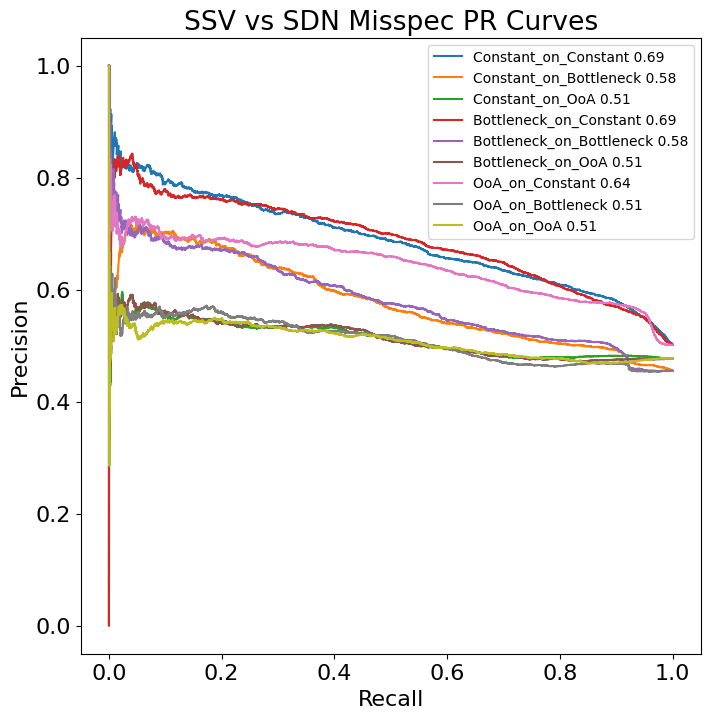

In [9]:
swp_aucs = []
for i in df_dict.keys():
    swp_prec, swp_rec, pr_swp_auc, prec, rec, pr_auc = plot_prec_recall(df_dict[i])
    swp_aucs.append(pr_swp_auc)
    plt.plot(swp_rec, swp_prec, label=f"{i} {pr_swp_auc:.2}")
    
handles, labels = plt.gca().get_legend_handles_labels()

order = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(swp_aucs))][::-1]
plt.legend(fontsize=10)
plt.title("SSV vs SDN Misspec PR Curves")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.savefig("Misspec_SDNSSV_PR.pdf")

In [10]:
for i in df_dict.keys():
    df = df_dict[i]
    #SSV
    ssv_df = df[df["sweep"] == "ssv"]
    plt.scatter(ssv_df["s_val"], ssv_df["ssv_sval"])
    
    x = ssv_df["s_val"]
    y = ssv_df["ssv_sval"]
    
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x+b, "-", color="black")

    plt.annotate(
        f"""r^2 of {i}: {np.round(r2_score(x, y), 2)}""",
        (0.01, 0.26),
    )
    plt.title(f"{i} SSV True vs Est Selection Coeff")
    plt.ylabel("Est Sel Coeff")
    plt.ylabel("True Sel Coeff")
    plt.ylim(0, 0.28)
    plt.xlim(0, 0.28)
    plt.savefig(f"{i} SSV True vs Est Selection Coeff.png".replace(" ","_"), dpi=500)
    plt.clf()

    #SDN
    sdn_df = df[df["sweep"] == "sdn"]
    x = sdn_df["s_val"]
    y = sdn_df["ssv_sval"]
    
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x+b, "-", color="black")

    plt.annotate(
        f"""r^2 of {i}: {np.round(r2_score(x, y), 2)}""",
        (0.01, 0.26),
    )
    plt.title(f"{i} SDN True vs Est Selection Coeff")
    plt.ylabel("Est Sel Coeff")
    plt.ylabel("True Sel Coeff")
    plt.scatter(sdn_df["s_val"], sdn_df["sdn_sval"])
    plt.ylim(0, 0.28)
    plt.xlim(0, 0.28)
    plt.savefig(f"{i} SDN True vs Est Selection Coeff.png".replace(" ","_"), dpi=500)
    plt.clf()


<Figure size 800x800 with 0 Axes>

In [11]:
ooa_stats = pd.read_csv("results/data/OoA_stats.csv")
bottle_stats = pd.read_csv("results/data/bottleneck_stats.csv")

In [12]:
ooa_stats.head()

,rep,sweep,selcoeff,fit_pval,fet_pval
0,0,neut,0.0,0.955402,0.752371
1,1,neut,0.0,0.378262,0.341649
2,10,neut,0.0,0.605541,1.000000
3,100,neut,0.0,0.795111,0.747527
4,1000,neut,0.0,0.574097,1.000000


In [13]:
ooa_stats["true_sweep"] = np.where(ooa_stats["sweep"] == "neut", 0, 1)
bottle_stats["true_sweep"] = np.where(bottle_stats["sweep"] == "neut", 0, 1)

ooa_stats["pred_sweep"] = np.where(ooa_stats["fet_pval"] > 0.05, 0, 1)
bottle_stats["pred_sweep"] = np.where(bottle_stats["fet_pval"] > 0.05, 0, 1)


In [14]:
ooa_stats.head()

,rep,sweep,selcoeff,fit_pval,fet_pval,true_sweep,pred_sweep
0,0,neut,0.0,0.955402,0.752371,0,0
1,1,neut,0.0,0.378262,0.341649,0,0
2,10,neut,0.0,0.605541,1.000000,0,0
3,100,neut,0.0,0.795111,0.747527,0,0
4,1000,neut,0.0,0.574097,1.000000,0,0


0.9157321297103724
0.6851093420598944


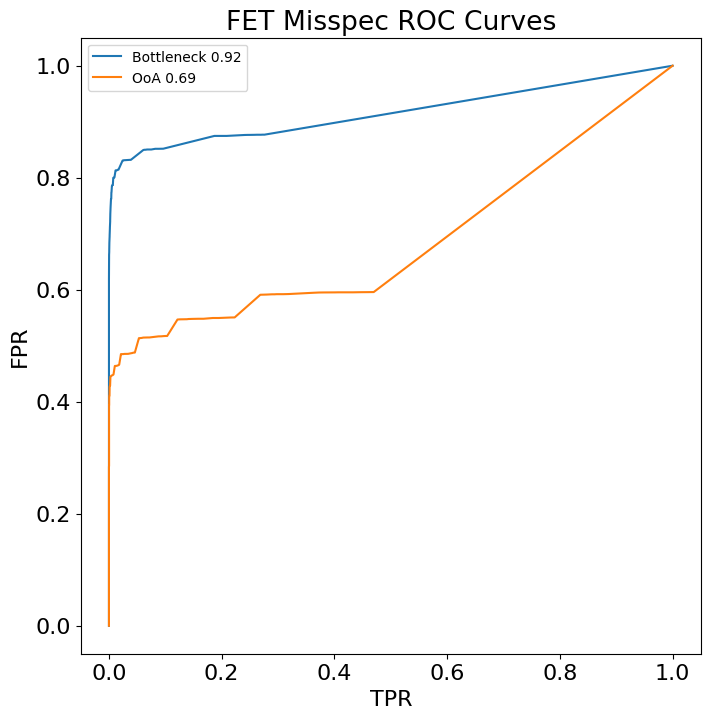

In [15]:
aucs = []
for name, df in zip(["Bottleneck", "OoA"], [bottle_stats, ooa_stats]):
    fpr, tpr, thresh = roc_curve(df["true_sweep"], 1 - df["fet_pval"])
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    plt.plot(fpr, tpr, label=f"{name} {roc_auc:.2}")
    
#handles, labels = plt.gca().get_legend_handles_labels()

#order = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(aucs))][::-1]
plt.legend(fontsize=10)
plt.title("FET Misspec ROC Curves")
plt.ylabel("FPR")
plt.xlabel("TPR")
plt.savefig("Misspec_FET_ROC.pdf")

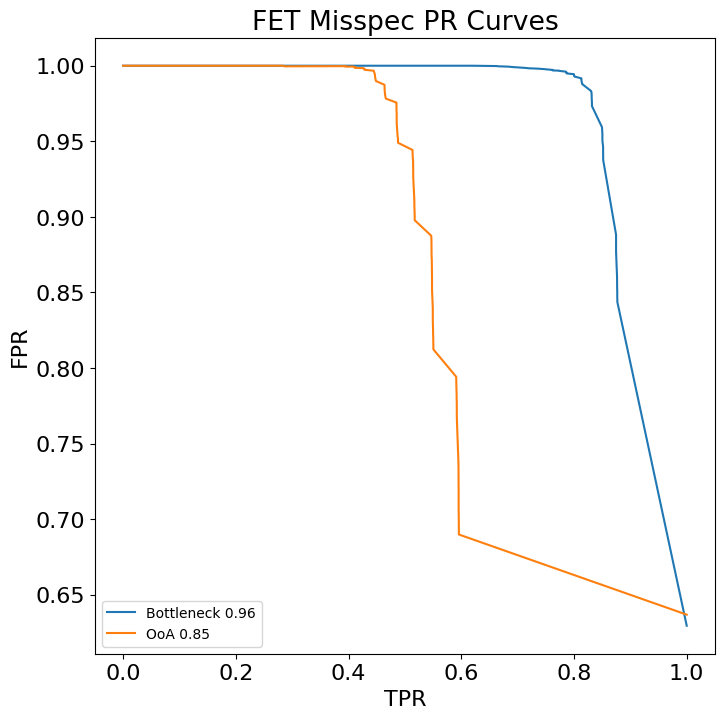

In [16]:
aucs = []
for name, df in zip(["Bottleneck", "OoA"], [bottle_stats, ooa_stats]):
    prec, rec, thresh = precision_recall_curve(df["true_sweep"], 1 - df["fet_pval"])
    pr_auc = auc(rec, prec)
    plt.plot(rec, prec, label=f"{name} {pr_auc:.2}")
    
#handles, labels = plt.gca().get_legend_handles_labels()

#order = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(aucs))][::-1]
plt.legend(fontsize=10)
plt.title("FET Misspec PR Curves")
plt.ylabel("FPR")
plt.xlabel("TPR")
plt.savefig("Misspec_FET_PR.pdf")